<h1> Implémentation du schéma de Rusanov - CAS 2D </h1>

Voici le code à partir duquel nous avons obtenu les graphes du rapport. Ce code permet aussi de générer des fichier .gif et ainsi de visualiser les évolutions (hauteur d'eau et débit) au cours du temps.

<h2>Équations dans le cas 2D :</h2>

$$ \frac{\partial h}{\partial t} + \frac{\partial hu}{\partial x} + \frac{\partial hv}{\partial y} = 0$$

$$ \frac{\partial hu}{\partial t} + \frac{\partial}{\partial x} ( hu^2 + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( huv + \frac{gh^2}{2} ) = 0$$

$$ \frac{\partial hv}{\partial t} + \frac{\partial}{\partial x} ( huv + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( hv^2 + \frac{gh^2}{2} ) = 0$$

## Importations

In [1]:
import math as math # Pour les fonctions math

import matplotlib.pyplot as plt # Pour l'affichage des graphes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits import mplot3d 

plt.rc('font', size=20)

import numpy as np # Pour les tableaux numpy
import imageio # Pour faire des .gif

## Paramètres du problème

In [71]:
g=1 # Constante gravitationnelle

xMin=0 # Bord gauche du domaine
xMax=100 # Bord droit du domaine

yMin = 0 #Bord bas du domaine
yMax = 100 #Bord haut du domaine

N=64 # Nombre de points (strictement à l'intérieur)
# Donc au total, on considère (N+2)^2 points avec les bords

h=(xMax-xMin)/(N+1) # Pas du maillage spatial, le même pour X et Y

Tmax=10 # Temps final de la simulation
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

## Conditions initiales et Topographie

Dans la cellule ci-dessous, nous définissons la discrétisation de l'axe des abscisses $\textbf{X}$, ainsi que la topographie $\textbf{Z}$ et les profils initiaux de la hauteur d'eau $h$ et du débit $q$. Le code en commentaire correspond à différentes initialisations possibles. Pour le suite, notons 
$\textbf{U}=
\begin{pmatrix}
   h \\
   q \\
\end{pmatrix}
\in\mathbb{R}^{2}$ 
le vecteur inconnu.

In [72]:
X,Y=np.mgrid[xMin:xMax+2*h/3:h,yMin:yMax+2*h/3:h] # Discrétisation de [xMin, xMax] et [yMin, yMax]
XY = X+Y*1j

W0 = np.ones([N+2,N+2]) # Discrétisation de h
W1 = np.ones([N+2,N+2]) # Discrétisation de hu
W2 = np.ones([N+2,N+2]) # Discrétisation de hv

# Définitions du h initial ------------------------------------

# Hauteur de l'eau en escalier 
# W0[0,0:(N+2)//3]   = 3
# W0[0,(N+2)//3:N+2] = 1.25

# Hauteur de l'eau constante
# W0[0,:]=1

# Hauteur de l'eau en bosse
W0 = 1+5/(4 + .01*( (X-50)**2 + (Y-50)**2 ) )


# Définitions du débit initial ------------------------------------

# Débit de l'eau constant
W1[:,:]=0
W2[:,:]=0

## Nombre de sauvegardes durant la simulation

Quelques variables qui vont nous servir pour enregistrer des étapes de la simulation, sans pour autant les sauvegarder toutes. Sans ça, le nombre d'images à sauver deviendrait vite trop important.

In [73]:
nSauvegarde=100 # Nombre de sauvegardes au cours de la simulation
tSauvegarde=[False for i in range(nSauvegarde)]
images=[]
k=0 # Nombre de sauvegardes déjà effectuées

## Affichage des images

La fonction ci-dessous permet de gérer l'affichage de la solution. Elle est suivie d'un test. Les graphes qui s'affichent sont ceux de $h$ et $q$ à $t=0$.

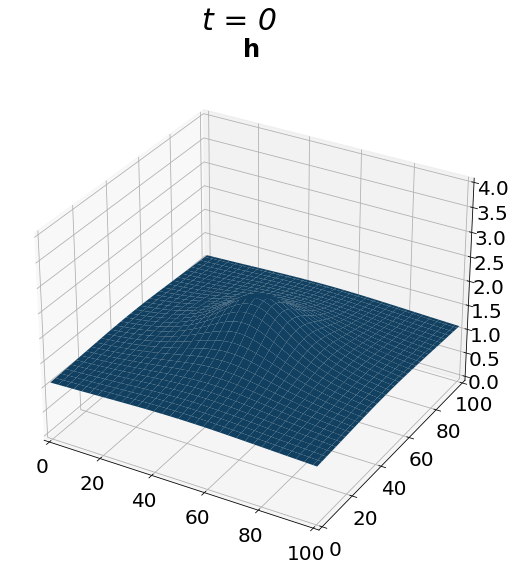

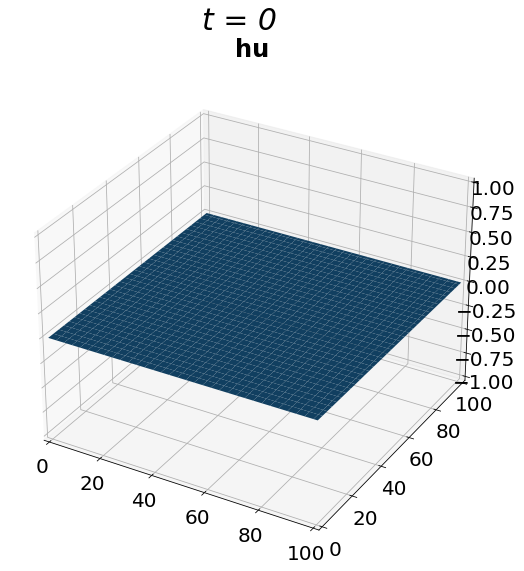

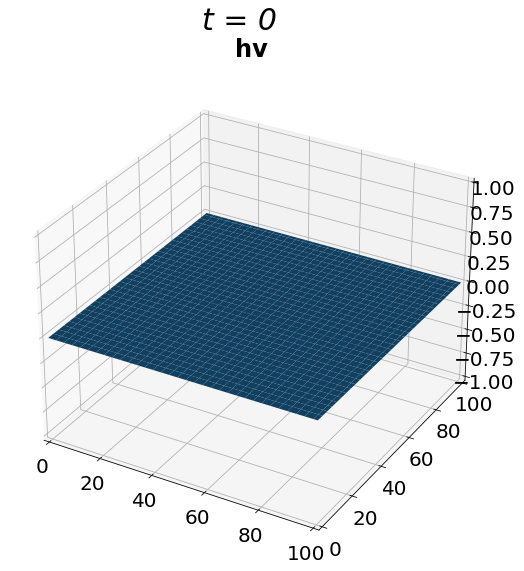

In [74]:
def affiche_W(t=0,index=0):
    
    #index : suivant que l'on veuille afficher h, u ou v
    
    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
        
    plt.show()
    
#Affichage de h, u et v
affiche_W()
affiche_W(index=1)
affiche_W(index=2)

## Sauvegarde des images

_enregistre_W_ effectue un traitement identique à _affiche_W_. La seule différence est qu'elle enregistre le plot dans le répertoire courant plutôt que de l'afficher.

In [75]:
def enregistre_W(t,index=0):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
      
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
    

    fig.canvas.draw()
    image_from_plot=np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot=image_from_plot.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    
    images.append(image_from_plot)
   
    plt.close()
    
enregistre_W(0,index=0)

<h2> Fonctions intervenant dans le schéma </h2>

En posant : $W = \left[ {\begin{array}{c}   h \\    hu \\    hv \\  \end{array} } \right] $ ; $ F(W) = \left[ {\begin{array}{c}   hu \\    hu^2 + \frac{gh^2}{2}  \\    huv + \frac{gh^2}{2} \\  \end{array} } \right] $ ; $ G(W) = \left[ {\begin{array}{c}   hv \\    huv + \frac{gh^2}{2}  \\    hv^2 + \frac{gh^2}{2} \\  \end{array} } \right] $ 

Avec $h$ la hauteur de l'eau, $u$ sa vitesse suivant la direction $x$ et $v$ sa vitesse suivant la direction $y$.

On a le système suivant :

$$ \frac{\partial W}{\partial t} + \frac{\partial F(W)}{\partial x} + \frac{\partial G(W)}{\partial y} = 0 $$

En identifiant $F(W)$ au flux suivant $x$ et $G(W)$ au flux suivant $y$.

En s'inspirant de ce qui a été fait dans le cas 1D, on discrétise de la manière suivante :

$$ \frac{ W_{i,j}^{n+1} - W_{i,j}^{n} }{\Delta t} + \frac{ F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} }{\Delta x} + \frac{G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} }{\Delta y} = 0 $$

Ce qui nous donne finalement :

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$

Avec : 

$$ F_{i+\frac{1}{2},j} =  \frac{ F(W_{i+1,j}) + F(W_{i,j}) }{2} - c \frac{ W_{i+1,j} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i+1,j}} \sup_{k = 1,2} | \lambda _k(W) | $$

et

$$ G_{i,j+\frac{1}{2}} =  \frac{ G(W_{i,j+1}) + G(W_{i,j}) }{2} - c \frac{ W_{i,j+1} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i,j+1}} \sup_{k = 1,2} | \lambda _k(W) | $$


In [76]:
def F(w0,w1,w2):
    return np.array([w1 , w1**2 / w0 + g * w0**2 / 2 , w1*w2/w0 + g * w0**2])

def G(w0,w1,w2):
    return np.array([w2 , w1*w2/ w0 + g * w0**2 / 2 , w2**2 /w0 + g * w0**2])


def vmaxF(i,j): #vmax du premier système : u , u+sqrt(gh) ou u-sqrt(gh)
    
    res = W1[i,j] / W0[i,j]
    
    res = max(res,abs( W1[i,j]/W0[i,j] + math.sqrt(g*W0[i,j])))
    res = max(res,abs( W1[i,j]/W0[i,j] - math.sqrt(g*W0[i,j])))

    res = max(res,abs( W1[i+1,j]/W0[i+1,j] + math.sqrt(g*W0[i+1,j])))
    res = max(res,abs( W1[i+1,j]/W0[i+1,j] - math.sqrt(g*W0[i+1,j])))

    return res

def vmaxG(i,j): #vmax du deuxième système : v , v+sqrt(gh) ou v-sqrt(gh)
    
    res = W2[i,j] / W0[i,j]
    
    res = max(res,abs( W2[i,j]/W0[i,j] + math.sqrt(g*W0[i,j])))
    res = max(res,abs( W2[i,j]/W0[i,j] - math.sqrt(g*W0[i,j])))

    res = max(res,abs( W2[i,j+1]/W0[i,j+1] + math.sqrt(g*W0[i,j+1])))
    res = max(res,abs( W2[i,j+1]/W0[i,j+1] - math.sqrt(g*W0[i,j+1])))

    return(res)

def F_ronde(i,j):
    termeW = np.array([ W0[i+1,j]-W0[i,j] , W1[i+1,j]-W1[i,j] ,W2[i+1,j]-W2[i,j] ] )/2
    
    return (F(W0[i+1,j],W1[i+1,j],W2[i+1,j])+F(W0[i,j],W1[i,j],W2[i,j]))/2-vmaxF(i,j) * termeW

def G_ronde(i,j):
    termeW = np.array([ W0[i,j+1]-W0[i,j] , W1[i,j]-W1[i,j+1] ,W2[i,j+1]-W2[i,j] ] )/2
    
    return (G(W0[i,j+1],W1[i,j+1],W2[i,j+1])+G(W0[i,j],W1[i,j],W2[i,j]))/2-vmaxG(i,j) * termeW

In [77]:
def conditionBord():

    # Conditions aux bords sur h
    W0[:,0] = W0[:,1]
    W0[:,N+1] = W0[:,N]
    W0[0,:] = W0[1,:]
    W0[N+1,:] = W0[N,:]
    
    # Conditions aux bords sur hu
    W1[:,0] = W1[:,1]
    W1[:,N+1] = W1[:,N]
    W1[0,:] = W1[1,:]
    W1[N+1,:] = W1[N,:]
    
    # Conditions aux bords sur hv
    W2[:,0] = W2[:,1]
    W2[:,N+1] = W2[:,N]
    W2[0,:] = W2[1,:]
    W2[N+1,:] = W2[N,:]

<h2> Pour rappel : </h2>

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$


In [78]:
while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = 0
    for i in range(0, N+1):
        for j in range(0,N+1):
            M = max(M, vmaxF(i,j))
            M = max(M, vmaxG(i,j))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(1, N+1):
        for j in range(1, N+1):

            W = np.array([ W0[i,j],W1[i,j],W2[i,j] ])
            W = W - tau/h * ( F_ronde(i,j) - F_ronde(i-1,j) ) #Terme avec les F ronde
            W = W - tau/h * ( G_ronde(i,j) - G_ronde(i,j-1) ) #Terme avec les G ronde
            
            W0[i,j] = W[0] 
            W1[i,j] = W[1]
            W2[i,j] = W[2]

    conditionBord() #Conditions aux bords sur h , hu et hv
    
    t+=tau
    n+=1
    
    print("Nombre d'itérations : " + str(n) + " | t = "+ str(t))

    if (t > Tmax/nSauvegarde*k and (k<nSauvegarde) and (not tSauvegarde[k])):
        enregistre_W(t,index=0)
        tSauvegarde[j]=True
        k+=1

imageio.mimsave('movie.gif', images)
print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 1 | t = 0.41059298953220114
Nombre d'itérations : 2 | t = 0.8018194820472611
Nombre d'itérations : 3 | t = 1.179004861713083
Nombre d'itérations : 4 | t = 1.5455372128974347
Nombre d'itérations : 5 | t = 1.9042009712800816
Nombre d'itérations : 6 | t = 2.2565262967267516
Nombre d'itérations : 7 | t = 2.603144730565585
Nombre d'itérations : 8 | t = 2.945349430672488
Nombre d'itérations : 9 | t = 3.2836964536454234
Nombre d'itérations : 10 | t = 3.618464091823297
Nombre d'itérations : 11 | t = 3.9502671374057754
Nombre d'itérations : 12 | t = 4.279297410857724
Nombre d'itérations : 13 | t = 4.60625742615362
Nombre d'itérations : 14 | t = 4.930800521509439
Nombre d'itérations : 15 | t = 5.253372322230497
Nombre d'itérations : 16 | t = 5.57427323390875
Nombre d'itérations : 17 | t = 5.859142596764105
Nombre d'itérations : 18 | t = 6.070416486754105
Nombre d'itérations : 19 | t = 6.2237385956383005
Nombre d'itérations : 20 | t = 6.338236993418781
Nombre d'itérations : 

Nombre d'itérations : 167 | t = 8.212798864550775
Nombre d'itérations : 168 | t = 8.21775013101337
Nombre d'itérations : 169 | t = 8.222661675069082
Nombre d'itérations : 170 | t = 8.227534226725252
Nombre d'itérations : 171 | t = 8.232368495151661
Nombre d'itérations : 172 | t = 8.237165169488248
Nombre d'itérations : 173 | t = 8.241924919612844
Nombre d'itérations : 174 | t = 8.246648396871395
Nombre d'itérations : 175 | t = 8.251336234772953
Nombre d'itérations : 176 | t = 8.255989049651552
Nombre d'itérations : 177 | t = 8.260607441296905
Nombre d'itérations : 178 | t = 8.265191993555765
Nombre d'itérations : 179 | t = 8.26974327490561
Nombre d'itérations : 180 | t = 8.274261839002223
Nombre d'itérations : 181 | t = 8.27874822520265
Nombre d'itérations : 182 | t = 8.283202959064846
Nombre d'itérations : 183 | t = 8.28762655282534
Nombre d'itérations : 184 | t = 8.292019505856045
Nombre d'itérations : 185 | t = 8.29638230510136
Nombre d'itérations : 186 | t = 8.300715425496593
Nombr

Nombre d'itérations : 332 | t = 8.748107050825826
Nombre d'itérations : 333 | t = 8.750401593055091
Nombre d'itérations : 334 | t = 8.752689495172413
Nombre d'itérations : 335 | t = 8.754970802440553
Nombre d'itérations : 336 | t = 8.757245559640712
Nombre d'itérations : 337 | t = 8.759513811079689
Nombre d'itérations : 338 | t = 8.76177560059691
Nombre d'itérations : 339 | t = 8.764030971571326
Nombre d'itérations : 340 | t = 8.766279966928195
Nombre d'itérations : 341 | t = 8.768522629145732
Nombre d'itérations : 342 | t = 8.770759000261648
Nombre d'itérations : 343 | t = 8.772989121879577
Nombre d'itérations : 344 | t = 8.775213035175373
Nombre d'itérations : 345 | t = 8.777430780903305
Nombre d'itérations : 346 | t = 8.779642399402146
Nombre d'itérations : 347 | t = 8.78184793060114
Nombre d'itérations : 348 | t = 8.784047414025874
Nombre d'itérations : 349 | t = 8.786240888804045
Nombre d'itérations : 350 | t = 8.788428393671117
Nombre d'itérations : 351 | t = 8.790609966975888
No

Nombre d'itérations : 497 | t = 9.060403358528498
Nombre d'itérations : 498 | t = 9.06199369094669
Nombre d'itérations : 499 | t = 9.063581295751012
Nombre d'itérations : 500 | t = 9.06516618478323
Nombre d'itérations : 501 | t = 9.066748369808648
Nombre d'itérations : 502 | t = 9.06832786251742
Nombre d'itérations : 503 | t = 9.069904674525931
Nombre d'itérations : 504 | t = 9.071478817378237
Nombre d'itérations : 505 | t = 9.073050302547568
Nombre d'itérations : 506 | t = 9.074619141437896
Nombre d'itérations : 507 | t = 9.076185345385582
Nombre d'itérations : 508 | t = 9.077748925661087
Nombre d'itérations : 509 | t = 9.079309893470755
Nombre d'itérations : 510 | t = 9.08086825995868
Nombre d'itérations : 511 | t = 9.08242403620863
Nombre d'itérations : 512 | t = 9.083977233246083
Nombre d'itérations : 513 | t = 9.085527862040303
Nombre d'itérations : 514 | t = 9.087075933506526
Nombre d'itérations : 515 | t = 9.088621458508213
Nombre d'itérations : 516 | t = 9.090164447859394
Nombr

Nombre d'itérations : 662 | t = 9.293626449509306
Nombre d'itérations : 663 | t = 9.294895510665372
Nombre d'itérations : 664 | t = 9.296162087172323
Nombre d'itérations : 665 | t = 9.29742618923483
Nombre d'itérations : 666 | t = 9.298687826996698
Nombre d'itérations : 667 | t = 9.299947010540999
Nombre d'itérations : 668 | t = 9.30120374989023
Nombre d'itérations : 669 | t = 9.302458055006483
Nombre d'itérations : 670 | t = 9.303709935791636
Nombre d'itérations : 671 | t = 9.304959402087556
Nombre d'itérations : 672 | t = 9.306206463676324
Nombre d'itérations : 673 | t = 9.307451130280466
Nombre d'itérations : 674 | t = 9.30869341156321
Nombre d'itérations : 675 | t = 9.309933317128742
Nombre d'itérations : 676 | t = 9.311170856522489
Nombre d'itérations : 677 | t = 9.312406039231403
Nombre d'itérations : 678 | t = 9.31363887468427
Nombre d'itérations : 679 | t = 9.314869372252017
Nombre d'itérations : 680 | t = 9.316097541248045
Nombre d'itérations : 681 | t = 9.317323390928557
Nomb

Nombre d'itérations : 827 | t = 9.475464582600877
Nombre d'itérations : 828 | t = 9.4764289078917
Nombre d'itérations : 829 | t = 9.477391903027932
Nombre d'itérations : 830 | t = 9.47835357309655
Nombre d'itérations : 831 | t = 9.479313923167265
Nombre d'itérations : 832 | t = 9.480272958293167
Nombre d'itérations : 833 | t = 9.481230683511408
Nombre d'itérations : 834 | t = 9.482187103843925
Nombre d'itérations : 835 | t = 9.483142224298229
Nombre d'itérations : 836 | t = 9.484096049868214
Nombre d'itérations : 837 | t = 9.485048585535036
Nombre d'itérations : 838 | t = 9.485999836268027
Nombre d'itérations : 839 | t = 9.486949807025647
Nombre d'itérations : 840 | t = 9.487898502756497
Nombre d'itérations : 841 | t = 9.488845928400355
Nombre d'itérations : 842 | t = 9.489792088889267
Nombre d'itérations : 843 | t = 9.49073698914866
Nombre d'itérations : 844 | t = 9.4916806340985
Nombre d'itérations : 845 | t = 9.492623028654473
Nombre d'itérations : 846 | t = 9.493564177729183
Nombre

Nombre d'itérations : 992 | t = 9.619617419672828
Nombre d'itérations : 993 | t = 9.6204123858277
Nombre d'itérations : 994 | t = 9.621206505149939
Nombre d'itérations : 995 | t = 9.621999779127622
Nombre d'itérations : 996 | t = 9.622792209251012
Nombre d'itérations : 997 | t = 9.623583797012312
Nombre d'itérations : 998 | t = 9.624374543905436
Nombre d'itérations : 999 | t = 9.62516445142577
Nombre d'itérations : 1000 | t = 9.625953521069942
Nombre d'itérations : 1001 | t = 9.626741754335601
Nombre d'itérations : 1002 | t = 9.627529152721191
Nombre d'itérations : 1003 | t = 9.628315717725728
Nombre d'itérations : 1004 | t = 9.629101450848593
Nombre d'itérations : 1005 | t = 9.629886353589319
Nombre d'itérations : 1006 | t = 9.630670427447395
Nombre d'itérations : 1007 | t = 9.631453673922065
Nombre d'itérations : 1008 | t = 9.632236094512137
Nombre d'itérations : 1009 | t = 9.633017690715803
Nombre d'itérations : 1010 | t = 9.633798464030459
Nombre d'itérations : 1011 | t = 9.6345784

Nombre d'itérations : 1154 | t = 9.738349323598808
Nombre d'itérations : 1155 | t = 9.739025188235216
Nombre d'itérations : 1156 | t = 9.739700418313952
Nombre d'itérations : 1157 | t = 9.740375014925048
Nombre d'itérations : 1158 | t = 9.74104897915617
Nombre d'itérations : 1159 | t = 9.741722312092625
Nombre d'itérations : 1160 | t = 9.742395014817362
Nombre d'itérations : 1161 | t = 9.74306708841098
Nombre d'itérations : 1162 | t = 9.743738533951733
Nombre d'itérations : 1163 | t = 9.744409352515534
Nombre d'itérations : 1164 | t = 9.74507954517596
Nombre d'itérations : 1165 | t = 9.745749113004253
Nombre d'itérations : 1166 | t = 9.74641805706933
Nombre d'itérations : 1167 | t = 9.747086378437789
Nombre d'itérations : 1168 | t = 9.747754078173905
Nombre d'itérations : 1169 | t = 9.748421157339644
Nombre d'itérations : 1170 | t = 9.749087616994661
Nombre d'itérations : 1171 | t = 9.749753458196311
Nombre d'itérations : 1172 | t = 9.750418681999648
Nombre d'itérations : 1173 | t = 9.

Nombre d'itérations : 1316 | t = 9.840260957574309
Nombre d'itérations : 1317 | t = 9.840846722563326
Nombre d'itérations : 1318 | t = 9.841432001949793
Nombre d'itérations : 1319 | t = 9.842016796500054
Nombre d'itérations : 1320 | t = 9.842601106978806
Nombre d'itérations : 1321 | t = 9.843184934149097
Nombre d'itérations : 1322 | t = 9.84376827877233
Nombre d'itérations : 1323 | t = 9.844351141608277
Nombre d'itérations : 1324 | t = 9.84493352341507
Nombre d'itérations : 1325 | t = 9.845515424949218
Nombre d'itérations : 1326 | t = 9.846096846965596
Nombre d'itérations : 1327 | t = 9.846677790217461
Nombre d'itérations : 1328 | t = 9.847258255456453
Nombre d'itérations : 1329 | t = 9.847838243432593
Nombre d'itérations : 1330 | t = 9.848417754894298
Nombre d'itérations : 1331 | t = 9.848996790588373
Nombre d'itérations : 1332 | t = 9.849575351260025
Nombre d'itérations : 1333 | t = 9.85015343765286
Nombre d'itérations : 1334 | t = 9.850731050508891
Nombre d'itérations : 1335 | t = 9

Nombre d'itérations : 1478 | t = 9.929312909891483
Nombre d'itérations : 1479 | t = 9.929828959440044
Nombre d'itérations : 1480 | t = 9.930344628639746
Nombre d'itérations : 1481 | t = 9.930859918037438
Nombre d'itérations : 1482 | t = 9.931374828178877
Nombre d'itérations : 1483 | t = 9.931889359608727
Nombre d'itérations : 1484 | t = 9.932403512870565
Nombre d'itérations : 1485 | t = 9.932917288506882
Nombre d'itérations : 1486 | t = 9.933430687059088
Nombre d'itérations : 1487 | t = 9.933943709067512
Nombre d'itérations : 1488 | t = 9.934456355071404
Nombre d'itérations : 1489 | t = 9.934968625608942
Nombre d'itérations : 1490 | t = 9.93548052121723
Nombre d'itérations : 1491 | t = 9.935992042432302
Nombre d'itérations : 1492 | t = 9.936503189789127
Nombre d'itérations : 1493 | t = 9.937013963821608
Nombre d'itérations : 1494 | t = 9.937524365062586
Nombre d'itérations : 1495 | t = 9.938034394043845
Nombre d'itérations : 1496 | t = 9.93854405129611
Nombre d'itérations : 1497 | t = 